For the reproduction of results presented in: Neural network – based analysis of multimodal bond distributions using their EXAFS spectra
Submitted to PRL

Nicholas Marcella1* , Stephen Lam,2 Vyacheslav Bryantsev,3 Santanu Roy3 and Anatoly I. Frenkel4,5*
1 Department of Chemistry, University of Illinois, Urbana, Illinois 61801, United States
2 Department of Chemical Engineering, University of Massachusetts Lowell, Lowell, Massachusetts 01854, United States
3 Chemical Sciences Division, Oak Ridge National Laboratory, Oak Ridge, Tennessee 37830, United States
4 Department of Materials Science and Chemical Engineering, Stony Brook University, Stony Brook, New York 11794, United States
5 Chemistry Division, Brookhaven National Laboratory, Upton, New York 11973, United States

Contact: nmarcella@bnl.gov, nmarcella.sbu@gmail.com



# Utilities

In [122]:
import pickle
import numpy as np
from numpy import pi, sin, cos, exp, sqrt, log, log10, zeros, ones, arange, interp, where, linspace
from scipy.fftpack import fft, ifft
from scipy.special import i0 as bessel_i0
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import glob
from fastdist import fastdist
from sklearn.model_selection import train_test_split
import os
import sys
import shutil

def k2(data):
    k, m = data.transpose()
    return np.asarray([k,k*k*m]).transpose()


def read_lines(filename):

    with open(filename, "rt") as fobject:
                f = fobject.readlines()
                lines_str = []

                for line in f:
                    lines_str.append(line.replace("\n", "").replace("\t", " "))
    return lines_str

# FT related functions taked from larch (https://xraypy.github.io/xraylarch/)

sqrtpi=sqrt(pi)
FT_WINDOWS = ('Kaiser-Bessel', 'Hanning', 'Parzen', 'Welch', 'Gaussian', 'Sine')
FT_WINDOWS_SHORT = tuple([a[:3].lower() for a in FT_WINDOWS])
mass_e = 9.1e-31;
hbar = 6.626e-34/(2*np.pi);

def ftwindow(x, xmin=None, xmax=None, dx=1, dx2=None,
             window='hanning', **kws):
    """
    create a Fourier transform window array.
    Parameters:
    -------------
      x:        1-d array array to build window on.
      xmin:     starting x for FT Window
      xmax:     ending x for FT Window
      dx:       tapering parameter for FT Window
      dx2:      second tapering parameter for FT Window (=dx)
      window:   name of window type
    Returns:
    ----------
    1-d window array.
    Notes:
    -------
    Valid Window names:
        hanning              cosine-squared taper
        parzen               linear taper
        welch                quadratic taper
        gaussian             Gaussian (normal) function window
        sine                 sine function window
        kaiser               Kaiser-Bessel function-derived window
    """
    if window is None:
        window = FT_WINDOWS_SHORT[0]
    nam = window.strip().lower()[:3]
    if nam not in FT_WINDOWS_SHORT:
        raise RuntimeError("invalid window name %s" % window)

    dx1 = dx
    if dx2 is None:  dx2 = dx1
    if xmin is None: xmin = min(x)
    if xmax is None: xmax = max(x)

    xstep = (x[-1] - x[0]) / (len(x)-1)
    xeps  = 1.e-4 * xstep
    x1 = max(min(x), xmin - dx1/2.0)
    x2 = xmin + dx1/2.0  + xeps
    x3 = xmax - dx2/2.0  - xeps
    x4 = min(max(x), xmax + dx2/2.0)

    if nam == 'fha':
        if dx1 < 0: dx1 = 0
        if dx2 > 1: dx2 = 1
        x2 = x1 + xeps + dx1*(xmax-xmin)/2.0
        x3 = x4 - xeps - dx2*(xmax-xmin)/2.0
    elif nam == 'gau':
        dx1 = max(dx1, xeps)

    def asint(val): return int((val+xeps)/xstep)
    i1, i2, i3, i4 = asint(x1), asint(x2), asint(x3), asint(x4)
    i1, i2 = max(0, i1), max(0, i2)
    i3, i4 = min(len(x)-1, i3), min(len(x)-1, i4)
    if i2 == i1: i1 = max(0, i2-1)
    if i4 == i3: i3 = max(i2, i4-1)
    x1, x2, x3, x4 = x[i1], x[i2], x[i3], x[i4]
    if x1 == x2: x2 = x2+xeps
    if x3 == x4: x4 = x4+xeps
    # initial window
    fwin =  zeros(len(x))
    if i3 > i2:
        fwin[i2:i3] = ones(i3-i2)

    # now finish making window
    if nam in ('han', 'fha'):
        fwin[i1:i2+1] = sin((pi/2)*(x[i1:i2+1]-x1) / (x2-x1))**2
        fwin[i3:i4+1] = cos((pi/2)*(x[i3:i4+1]-x3) / (x4-x3))**2
    elif nam == 'par':
        fwin[i1:i2+1] =     (x[i1:i2+1]-x1) / (x2-x1)
        fwin[i3:i4+1] = 1 - (x[i3:i4+1]-x3) / (x4-x3)
    elif nam == 'wel':
        fwin[i1:i2+1] = 1 - ((x[i1:i2+1]-x2) / (x2-x1))**2
        fwin[i3:i4+1] = 1 - ((x[i3:i4+1]-x3) / (x4-x3))**2
    elif nam  in ('kai', 'bes'):
        cen  = (x4+x1)/2
        wid  = (x4-x1)/2
        arg  = 1 - (x-cen)**2 / (wid**2)
        arg[where(arg<0)] = 0
        if nam == 'bes': # 'bes' : ifeffit 1.0 implementation of kaiser-bessel
            fwin = bessel_i0(dx* sqrt(arg)) / bessel_i0(dx)
            fwin[where(x<=x1)] = 0
            fwin[where(x>=x4)] = 0
        else: # better version
            scale = max(1.e-10, bessel_i0(dx)-1)
            fwin = (bessel_i0(dx * sqrt(arg)) - 1) / scale
    elif nam == 'sin':
        fwin[i1:i4+1] = sin(pi*(x4-x[i1:i4+1]) / (x4-x1))
    elif nam == 'gau':
        cen  = (x4+x1)/2
        fwin =  exp(-(((x - cen)**2)/(2*dx1*dx1)))
    return fwin

def xftf_prep(k, chi, kmin=0, kmax=20, kweight=2, dk=1, dk2=None,
                window='kaiser', nfft=2048, kstep=0.05):
    """
    calculate weighted chi(k) on uniform grid of len=nfft, and the
    ft window.
    Returns weighted chi, window function which can easily be multiplied
    and used in xftf_fast.
    """
    if dk2 is None: dk2 = dk
    npts = int(1.01 + max(k)/kstep)
    k_max = max(max(k), kmax+dk2)
    k_   = kstep * np.arange(int(1.01+k_max/kstep), dtype='float64')
    chi_ = interp(k_, k, chi)
    win  = ftwindow(k_, xmin=kmin, xmax=kmax, dx=dk, dx2=dk2, window=window)
    return ((chi_[:npts] *k_[:npts]**kweight), win[:npts])

def xftf_fast(chi, nfft=2048, kstep=0.05, **kws):
    cchi = zeros(nfft, dtype='complex128')
    cchi[0:len(chi)] = chi
    return (kstep / sqrtpi) * fft(cchi)[:int(nfft/2)]

def xftr_fast(chir, nfft=2048, kstep=0.05, **kws):
    """
    calculate reverse XAFS Fourier transform, from chi(R) to
    chi(q), using common XAFS conventions.  This version demands
    chir be the complex chi(R) as created from xftf().
    It returns the complex array of chi(q) without putting any
    values into an output group.
    Parameters:
    -------------
      chir:     1-d array of chi(R) to be transformed
      nfft:     value to use for N_fft (2048).
      kstep:    value to use for delta_k (0.05).
    Returns:
    ----------
      complex 1-d array for chi(q).
    This is useful for repeated FTs, as inside loops.
    """
    cchi = zeros(nfft, dtype='complex128')
    cchi[0:len(chir)] = chir
    return  (4*sqrtpi/kstep) * ifft(cchi)[:int(nfft/2)]


kspace = np.arange(2,12.05,.05)
time_space = np.arange(0,np.pi,.01)
rmeshPrime = np.arange(0,6,.025)
def chi_r(r):
    return np.asarray(list(map(lambda k: (1/r**2)*np.sin(2*k*r), kspace)))

def xftr(r, chir=None, rmin=0, rmax=20, with_phase=False,
            dr=1, dr2=None, rw=0, window='kaiser', qmax_out=None,
            nfft=2048, kstep=0.05, **kws):
    """
    reverse XAFS Fourier transform, from chi(R) to chi(q).
    calculate reverse XAFS Fourier transform
    This assumes that chir_re and (optional chir_im are
    on a uniform r-grid given by r.
    Parameters:
    ------------
      r:        1-d array of distance, or group.
      chir:     1-d array of chi(R)
      group:    output Group
      qmax_out: highest *k* for output data (30 Ang^-1)
      rweight:  exponent for weighting spectra by r^rweight (0)
      rmin:     starting *R* for FT Window
      rmax:     ending *R* for FT Window
      dr:       tapering parameter for FT Window
      dr2:      second tapering parameter for FT Window
      window:   name of window type
      nfft:     value to use for N_fft (2048).
      kstep:    value to use for delta_k (0.05).
      with_phase: output the phase as well as magnitude, real, imag  [False]
    Returns:
    ---------
      None -- outputs are written to supplied group.
    Notes:
    -------
    Arrays written to output group:
        rwin               window Omega(R) (length of input chi(R)).
        q                  uniform array of k, out to qmax_out.
        chiq               complex array of chi(k).
        chiq_mag           magnitude of chi(k).
        chiq_re            real part of chi(k).
        chiq_im            imaginary part of chi(k).
        chiq_pha           phase of chi(k) if with_phase=True
                           (a noticable performance hit)
    Supports First Argument Group convention (with group member names 'r' and 'chir')
    """
    if 'rweight' in kws:
        rw = kws['rweight']

    r = r
    chir = chir
    
    rstep = r[1] - r[0]
    kstep = pi/(rstep*nfft)
    scale = 1.0

    cchir = zeros(nfft, dtype='complex128')
    r_    = rstep * arange(nfft, dtype='float64')

    cchir[0:len(chir)] = chir
    if chir.dtype == np.dtype('complex128'):
        scale = 0.5

    win = ftwindow(r_, xmin=rmin, xmax=rmax, dx=dr, dx2=dr2, window=window)
    out = scale * xftr_fast( cchir*win * r_**rw, kstep=kstep, nfft=nfft)
    if qmax_out is None: qmax_out = 30.0
    q = linspace(0, qmax_out, int(1.05 + qmax_out/kstep))
    nkpts = len(q)

    group = {}
    group['q'] = q
    mag = sqrt(out.real**2 + out.imag**2)
    group['rwin'] =  win[:len(chir)]
    group['chiq']     =  out[:nkpts]
    group['chiq_mag'] =  mag[:nkpts]
    group['chiq_re']  =  out.real[:nkpts]
    group['chiq_im']  =  out.imag[:nkpts]
    if with_phase:
        group['chiq_pha'] =  complex_phase(out[:nkpts])
    return group

def interpol(exafs):
    global kspace
    x, y = exafs.transpose()
    f1=interp1d(x, y, kind='cubic')
    test_real=f1(kspace)
    return test_real

def intpol(data, energymesh):
    """
    data format is [[energies1, mus1]...[energy_n, mus_n]]
    """
    return np.interp(energymesh, xp=data[0:,0], fp=data[0:,1])

def read_exafs_dat(file_path):
    return np.asarray([[float(s) for s in l.split()] for l in [l for l in read_lines(file_path) if l.split()[0] != '#']])[:,[2,5]]

# Make structures (one example)

## Functions

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from numpy import sqrt, trapz

def write_xyz_file(filename, coordinate_array):
    with open(filename, 'w') as file:
        file.write(str(len(coordinate_array)) + "\n")
        file.write("Ni atoms\n")
        for coordinates in coordinate_array:
            file.write(f"Ni {coordinates[0]} {coordinates[1]} {coordinates[2]}\n")

def normal_distro_S1(mean, std):
    global S1
    lower, upper = mean-.5, mean+.5
    mu, sigma = mean, std
    S1 = stats.norm(loc=mu, scale=sigma)

def normal_distro_S2(mean, std):
    global S2
    lower, upper = mean-.5, mean+.5
    mu, sigma = mean, std
    S2 = stats.norm(loc=mu, scale=sigma)

def normal_distro_S3(mean, std):
    global S3
    lower, upper = mean-.5, mean+.5
    mu, sigma = mean, std
    S3 = stats.norm(loc=mu, scale=sigma)

def normal_distro_S4(mean, std):
    global S4
    lower, upper = mean-.5, mean+.5
    mu, sigma = mean, std
    S4 = stats.norm(loc=mu, scale=sigma)

def integrate_mono(rdf ,rmesh, rrange):
    x,y = np.asarray([l for l in np.asarray([rmesh, rdf]).transpose() if rrange[0]<l[0]<rrange[1]]).transpose()
    return trapz(y,x)

def make_rdf_feff(distances, rmesh):
    digitized =np.digitize(distances
        , rmesh)
    unique, counts = np.unique(digitized, return_counts=True)
    counter = [0]*len(rmesh)
    for i in range(len(unique)):
        counter[unique[i]-1] = counts[i]/(rmesh[1]-rmesh[0])
    return np.asarray(counter)

def from_xyz(xyz, axis=-1):
    x, y, z = np.moveaxis(xyz, axis, 0)

    lea = np.empty_like(xyz)

    pre_selector = ((slice(None),) * lea.ndim)[:axis]

    xy_sq = x ** 2 + y ** 2
    lea[(*pre_selector, 0)] = np.sqrt(xy_sq + z ** 2)
    lea[(*pre_selector, 1)] = np.arctan2(np.sqrt(xy_sq), z)
    lea[(*pre_selector, 2)] = np.arctan2(y, x)

    return lea


def to_xyz(lea, axis=-1):
    l, e, a = np.moveaxis(lea, axis, 0)

    xyz = np.empty_like(lea)

    pre_selector = ((slice(None),) * xyz.ndim)[:axis]

    xyz[(*pre_selector, 0)] = l * np.sin(e) * np.cos(a)
    xyz[(*pre_selector, 1)] = l * np.sin(e) * np.sin(a)
    xyz[(*pre_selector, 2)] = l * np.cos(e)

    return xyz

def fibonacci_sphere(samples=1):

    points = []
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y*y)  # radius at y

        theta = phi * i  # golden angle increment

        x = np.cos(theta) * radius
        z = np.sin(theta) * radius

        points.append([x, y, z])

    return points

def fibonacci_sphere_with_rescaling(target_rho_values, samples=1):
    # Generate points on a unit sphere using the Fibonacci Sphere algorithm
    points = fibonacci_sphere(samples)
    
    # Rescale the points to match the target rho values
    rescaled_points = []
    for i in range(len(target_rho_values)):
        # Retrieve the original point coordinates
        x, y, z = points[i]
        
        # Compute the original rho value
        original_rho = np.sqrt(x**2 + y**2 + z**2)
        
        # Compute the rescaling factor
        rescaling_factor = target_rho_values[i] / original_rho
        
        # Rescale the coordinates by multiplying with the rescaling factor
        rescaled_x = x * rescaling_factor
        rescaled_y = y * rescaling_factor
        rescaled_z = z * rescaling_factor
        
        # Append the rescaled point to the list
        rescaled_points.append([rescaled_x, rescaled_y, rescaled_z])
    
    return from_xyz(rescaled_points)


### GA

import logging
import random
from deap import creator, base, tools, algorithms
import numpy as np

#logging.basicConfig(filename='A:\\Objective_training\\Bulk\\app.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)


def d_sphere(rtp1, rtp2):
    r1, th1, ph1 = rtp1.T
    r2, th2, ph2 = rtp2.T
    return np.sqrt(r1**2+r2**2-2*r1*r2*np.cos((th1-th2))-2*r1*r2*np.sin(th1)*np.sin(th2)*(np.cos((ph1-ph2))-1))


def sph_dis_matrix(list_of_points):
    n_points = len(list_of_points)
    list_of_points = np.array(list_of_points)

    # The newaxis index operator inserts a new axis into list_of_points, making it a column vector,
    # and with broadcasting feature of numpy, it computes the d_sphere over each pair.
    dm = d_sphere(list_of_points[np.newaxis, :, :], list_of_points[:, np.newaxis, :])

    return dm

def find_min(list_of_points):
    tri = sph_dis_matrix(list_of_points)
    
    # numpy.triu returns the upper triangle of an array and "k=1" excludes the main diagonal.
    # Since the matrix is symmetric and the diagonal is zero, we just need to consider the upper triangle of the matrix.
    tri_upper = np.triu(tri, k=1)
    
    # We find the minimum in the upper triangle. Here we consider only the non-zero values.
    min_val = tri_upper[tri_upper > 0].min()
    
    return min_val


def optimize_structure(a_structure):

    logging.info('Starting optimization of a structure')

    def reassemble_points(rhos, thetas_phis):
        num_points = len(rhos)
        points = np.zeros((num_points, 3))
        thetas = thetas_phis[:num_points]
        phis = thetas_phis[num_points:]

        for i in range(num_points):
            points[i] = [rhos[i], thetas[i], phis[i]]

        return points

    def mutate_individual(individual, low, up, indpb, sigma=0.1):
        num_points = len(individual)
        for i in range(num_points):
            if random.random() < indpb:
                individual[i] += random.gauss(0, sigma)
                individual[i] = max(low[i], min(up[i], individual[i]))  # Apply bounds
        return individual,

    # Define the fitness and individual classes
    if not hasattr(creator, 'FitnessMax'):
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if not hasattr(creator, 'Individual'):
        creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    # Define the number of points
    num_points = 54

    # Define the ranges for theta and phi
    theta_min, theta_max = -.02, .02
    phi_min, phi_max = -.02, .02

    # Define the bounds for theta and phi
    bounds = [(theta_min, theta_max)] * num_points + [(phi_min, phi_max)] * num_points 

    # Attribute generator: randomly initialize theta and phi for each point
    toolbox.register("attr_angles", random.uniform, phi_min, phi_max)
    toolbox.register("attr_angles_theta", random.uniform, theta_min, theta_max)

    # Structure initializer: create an individual by randomly initializing the angles
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_angles_theta, toolbox.attr_angles), n=num_points)

    # Population initializer
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Evaluate function: calculate the fitness as the negative of the minimum distance
    def evaluate(individual):
        thetas_i = individual[:num_points]
        phis_i = individual[num_points:]
        thetas_i = np.array(thetas_i)
        phis_i = np.array(phis_i)
        thetas = thetas_f + thetas_i
        phis = phis_f + phis_i
        points = reassemble_points(rhos, np.concatenate((thetas, phis)))
        return find_min(points),

    toolbox.register("evaluate", evaluate)

    # Genetic operators
    toolbox.register("select", tools.selTournament, tournsize=5)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutate_individual, low=[phi_min] * num_points + [theta_min] * num_points,
                    up=[phi_max] * num_points + [theta_max] * num_points, indpb=0.2)

    # Initialize structure
    rhos = a_structure[:,0]
    thetas_f = a_structure[:,1]
    phis_f = a_structure[:,2]

    saved = reassemble_points(rhos, np.concatenate((thetas_f, phis_f)))

    logging.info('saved created')

    # Define the population size and number of generations
    population_size = 100
    num_generations = 10

    num_iterations = 300

    for iteration in range(num_iterations):
        logging.info('Starting iteration %d' % iteration)
        rhos = saved[:,0]
        thetas_f = saved[:,1]
        phis_f = saved[:,2]

        # Create the initial population
        population = toolbox.population(n=population_size)

        # Evaluate the initial population
        fitnesses = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Define the hall of fame object
        hof = tools.HallOfFame(1)
        #logging.info('hof created')
        # Perform the genetic algorithm
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        population, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.5, ngen=num_generations,
                                            stats=stats, halloffame=hof, verbose=False)

        # Retrieve the best individual
        best_individual = hof[0]
        #logging.info('best individual retrieved')

        thetas_i = best_individual[:num_points]
        phis_i = best_individual[num_points:]
        thetas_i = np.array(thetas_i)
        phis_i = np.array(phis_i)
        thetas = thetas_f + thetas_i
        phis = phis_f + phis_i
        saved = reassemble_points(rhos, np.concatenate((thetas, phis)))
        #logging.info('saved updated')
        if find_min(saved) >= 2.23:
            #print(f'Stopping optimization: minimum of saved is {find_min(saved)} at iteration {iteration}.')
            break

    return saved


## One Example

### Setup a macrostate

In [5]:
# alpha is the lattice constant of Ni
alpha = 3.524
s = .07
# Shell 1
normal_distro_S1(alpha*sqrt(1/2), s)
# Shell 2
normal_distro_S2(alpha, s)
# Shell 3
normal_distro_S3(alpha*sqrt(3/2), s)
# Shell 4
normal_distro_S4(alpha*sqrt(2), s)

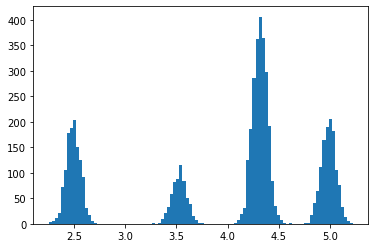

In [6]:
# Sample the macrostate to create microstates
# n_frames is the number of microstates
n_frames = 100
# n_1 is the number of bonds in shell 1
n_1=12
# n_2 is the number of bonds in shell 2
n_2=6
# n_3 is the number of bonds in shell 3
n_3=24
# n_4 is the number of bonds in shell 4
n_4=12
# all_bonds is the microstate
all_bonds = np.concatenate((S1.rvs(n_1), S2.rvs(n_2), S3.rvs(n_3), S4.rvs(n_4)))
# do it for n_frames times
for i in range(n_frames):
    all_bonds = np.concatenate((all_bonds, S1.rvs(n_1), S2.rvs(n_2), S3.rvs(n_3), S4.rvs(n_4)))
plt.hist(all_bonds, bins=100)
plt.show()

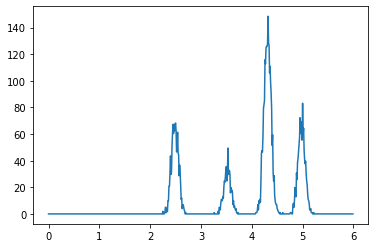

In [11]:
# create an RDF for the macrostate
n_atoms = 54
plt.plot(rmesh, n_atoms*np.mean(np.array([make_rdf_feff(l, rmesh) for l in all_bonds]),axis=0))

In [19]:
# check the coordination numbers
cn1 = integrate_mono(np.mean(np.array([make_rdf_feff(l, rmesh)*54 for l in all_bonds]),axis=0), rmesh, [2, 3])
cn2 = integrate_mono(np.mean(np.array([make_rdf_feff(l, rmesh)*54 for l in all_bonds]),axis=0), rmesh, [3, 3.8])
cn3 = integrate_mono(np.mean(np.array([make_rdf_feff(l, rmesh)*54 for l in all_bonds]),axis=0), rmesh, [4, 4.7])
cn4 = integrate_mono(np.mean(np.array([make_rdf_feff(l, rmesh)*54 for l in all_bonds]),axis=0), rmesh, [4.6, 5.5])
print(cn1, cn2, cn3, cn4)

12.0 6.000000000000003 24.0 12.009900990099016


### Use GA to make a 3D structure

In [22]:
# Set distribution



alpha = 3.524 
# Shell 1
normal_distro_S1(alpha*sqrt(1/2), .1)
# Shell 2
normal_distro_S2(alpha, .1)
# Shell 3
normal_distro_S3(alpha*sqrt(3/2), .1)
# Shell 4
normal_distro_S4(alpha*sqrt(2), .1)

n_frames = 50
n_1=12
n_2=6
n_3=24
n_4=12

partial_bonds = []



for i in range(n_frames):
    frame_list = []
    frame_list.append(S1.rvs(n_1))
    frame_list.append(S2.rvs(n_2))
    frame_list.append(S3.rvs(n_3))
    frame_list.append(S4.rvs(n_4))
    partial_bonds.append(frame_list)

a_structure_list = [np.concatenate((fibonacci_sphere_with_rescaling(pb[0], 12), fibonacci_sphere_with_rescaling(pb[1], 6), fibonacci_sphere_with_rescaling(pb[2], 24), fibonacci_sphere_with_rescaling(pb[3], 12))) for pb in partial_bonds]

In [25]:
optimized_structure = optimize_structure(a_structure_list[0])

In [32]:
# write initial structure to a file
# convert to xyz
# add the absorber at 0,0,0
write_xyz_file('.\\Data_Ni_Bulk\\GA\\Ni_Bulk_initial.xyz',  np.concatenate((np.array([[0,0,0]]),to_xyz(a_structure_list[0]))))

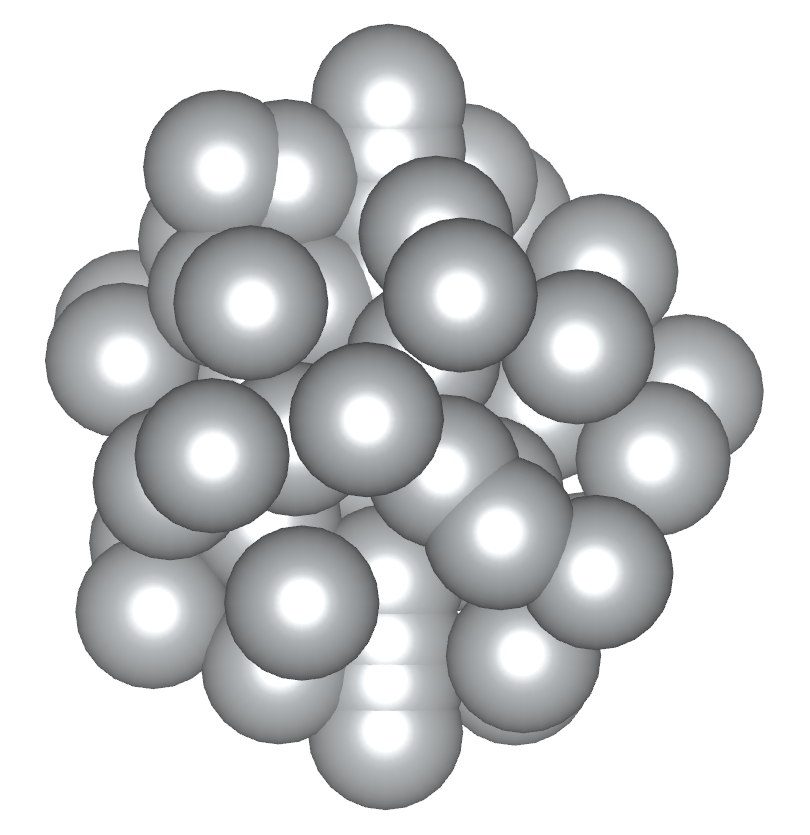

In [31]:
# write optimized structure to a file
# convert to xyz
# add the absorber at 0,0,0
write_xyz_file('.\\Data_Ni_Bulk\\GA\\Ni_Bulk.xyz',  np.concatenate((np.array([[0,0,0]]),to_xyz(optimized_structure))))

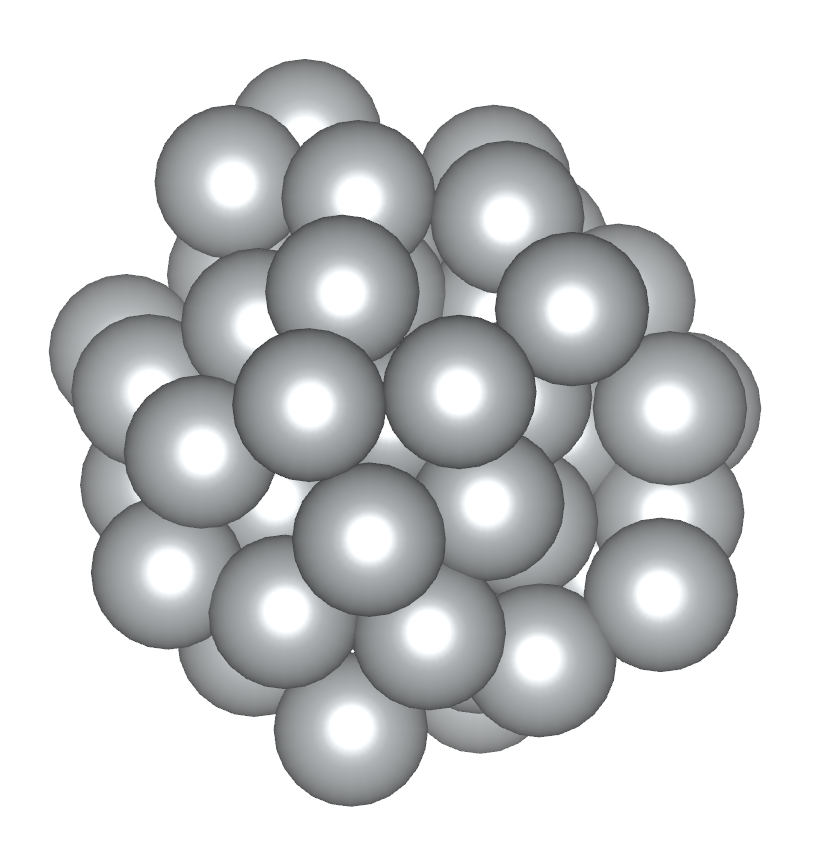

## Make all training structures

In [ ]:
# r is the scaling factor of the lattice constant

for r in [1, .99, 1.1, .98]:

# s is the standard deviation of the normal distribution

    for s in np.arange(0.07, 0.15, .01):

        alpha = 3.524 * r
        # Shell 1
        normal_distro_S1(alpha*sqrt(1/2), s)
        # Shell 2
        normal_distro_S2(alpha, s)
        # Shell 3
        normal_distro_S3(alpha*sqrt(3/2),s)
        # Shell 4
        normal_distro_S4(alpha*sqrt(2), s)

        n_frames = 50
        n_1=12
        n_2=6
        n_3=24
        n_4=12

        partial_bonds = []

        for i in range(n_frames):
            frame_list = []
            frame_list.append(S1.rvs(n_1))
            frame_list.append(S2.rvs(n_2))
            frame_list.append(S3.rvs(n_3))
            frame_list.append(S4.rvs(n_4))
            partial_bonds.append(frame_list)
        # create the inital structures
        a_structure_list = [np.concatenate((fibonacci_sphere_with_rescaling(pb[0], 12), fibonacci_sphere_with_rescaling(pb[1], 6), fibonacci_sphere_with_rescaling(pb[2], 24), fibonacci_sphere_with_rescaling(pb[3], 12))) for pb in partial_bonds]
        # optimize the structures
        optimized_structures = []
        for i in a_structure_list:
            optimized_structures.append(optimize_structure(i))
        # save the optimized structures
        with open('A:\\Objective_training\\Bulk_optimized_strucutres_'+str(r)+'_'+str(s)+'.pickle', 'wb') as handle:
            pickle.dump(optimized_structures, handle, protocol=pickle.HIGHEST_PROTOCOL)

# FEFF-related code

## Make FEFF input files

In [ ]:
# load optimized structures
all_opt_files = glob.glob("A:\\Objective_training\\*.pickle")


for i,opt in enumerate(all_opt_files):
    example=str(i)

    with open(opt, 'rb') as handle:
        optimized_structures = pickle.load(handle)

    n_atoms_total = 54
    all_results = np.array(optimized_structures)
    atom_symbol_dic_str_to_int = {'Ni':1}
    atom_ids = np.asarray(["Ni"]*n_atoms_total).astype('<U32').reshape(-1,1)
    atom_ids_int = np.asarray([1]*(n_atoms_total)).astype('<U32').reshape(-1,1)
    atom_ids_int = np.insert(atom_ids_int,0,[0])
    final_points_xyz = list(map(lambda x: to_xyz(x), all_results))
    final_points_xyz = list(map(lambda x: np.insert(x,0,np.array([0,0,0]),axis=0), final_points_xyz))
    master_set_x = list(map(lambda x: np.insert(x, 0, atom_ids_int, axis=1), final_points_xyz))
    master_set_x = np.array(master_set_x)

    ms_header_0=[['Edge','K'],
    ['S02', '1.0'],
    ['EXAFS', '20.0'],
    ['COREHOLE', 'FSR'],
    ['RPATH', '6'],
    ['CRITERIA', '0.0', '0.1'],
    ['SCF', '4.0', '0', '100', '0.2', '1'],
    ['POTENTIALS'],
    ['0', '28', 'Ni'],
    ['1', '28', 'Ni']]

    ms_header=make_head(ms_header_0)

    atom_symbol_dic = {'0':'Ni', '1':'Ni', '2':'Zn', '3':'K'}

    main="A:\\Objective_training\\Bulk_Ni\\Input"

    

    for i, stuff in enumerate(master_set_x):
        out=ms_header+"ATOMS\n"+make_atoms([[atom_symbol_dic[str(int(s))] for s in stuff[:,0]], [str(int(s)) for s in stuff[:,0]],stuff[:,1:]])+"\nEND"
        abs_dir=make_frame_dir(main,example)+"\\"+str(i)
        os.makedirs(abs_dir)
        with open(abs_dir+"\\feff.inp", "w") as f:
            f.write(out)


## Local FEFF calculation loop

In [ ]:
import subprocess
import concurrent.futures as confu
import os
import glob

def run_feff(feff_path):
    path = feff_path
    cmd = "run_feff.bat > feff.out"
    cwd = os.path.dirname(path)
    process = subprocess.run(cmd, shell=True, capture_output=True, text=True, cwd=cwd)
    if process.returncode != 0:
        print(f"stderr:\n{process.stderr}")  # print the standard error
        raise Exception(f"Command failed with return code {process.returncode}")
    print('done')
    return feff_path  # return something meaningful

def run_feff_calculation(max_process=4, feff_paths=[]):
    with confu.ThreadPoolExecutor(max_workers=max_process) as executor:
        futures = [executor.submit(run_feff, feff) for feff in feff_paths]
        for future in confu.as_completed(futures):
            try:
                print("job_id: " + str(future.result()) + " is done")
            except Exception as e:
                print(f"An error occurred: {e}")

def copy_to_folders(folders, file_to_copy):
    for folder in folders:
        # Get the base name of the file (without the directory part)
        base_name = os.path.basename(file_to_copy)
        # Construct the full path to the destination file
        destination_file = os.path.join(folder, base_name)
        shutil.copy(file_to_copy, destination_file)



all_feff_files=glob.glob("C:\\FEFF10Local\\Input2\\*\\*\\*feff.inp")
feff_folders= [l.replace("feff.inp", "") for l in all_feff_files]

# Copy run_feff.bat to all the folders
file_to_copy = r"C:\\FEFF10Local\bat\run_feff.bat"
copy_to_folders(feff_folders, file_to_copy)

all_feff_files=glob.glob("A:\\Objective_training\\Bulk_Ni\\Input\\*\\*\\*feff.inp")      
run_feff_calculation(max_process=4, feff_paths=all_feff_files)

# Make Training and Testing Data

## Training and validation data

In [89]:
# read FEFF files (structure is from feff.inp and spectra is from xmu.dat) and group into configuration averages (special_bois)
# define r grid
rmesh = np.arange(0,6,.1)

# This function reads the FEFF files and returns the EXAFS and RDF per configuration directory.
def specific_data(path):

    xmu_files=glob.glob(path+"\\*\\*xmu.dat")
    feff_files= [l.replace("xmu.dat", "feff.inp") for l in xmu_files]

    all_exafs_0_s=[]
    all_rdf_0_s=[]
    for i,spectra in enumerate(xmu_files):
        all_exafs_0_s.append(read_exafs_dat(spectra))
        all_coords=np.asarray([l.split() for l in read_lines(feff_files[i])[11:-1]])[:,0:3].astype(float)
        all_coords_index=np.asarray([l.split() for l in read_lines(feff_files[i])[11:-1]])[:,3].astype(float)
        all_coords_index_ni=all_coords[np.where(all_coords_index==1)]
        all_coords_index_abs=all_coords[np.where(all_coords_index==0)]

        distances_ni=[l for l in fastdist.vector_to_matrix_distance(all_coords_index_abs[0], all_coords_index_ni, fastdist.euclidean, "euclidean") if 0<l<6]

        all_rdf_0_s.append(make_rdf_feff(distances_ni, rmesh))


    all_exafs_0_s = np.asarray(all_exafs_0_s)
    all_exafs_0_s = [[l for l in s if 2<=l[0]<=12 ] for s in all_exafs_0_s]
    all_exafs_0_s = np.asarray(all_exafs_0_s)
    all_exafs_0_k2_s = []
    for spectrum in all_exafs_0_s:
        x, y = spectrum.transpose()
        all_exafs_0_k2_s.append(np.array([x,y*x**2]).transpose())
    all_exafs_0_k2_s = np.asarray(all_exafs_0_k2_s)

    bad_exafs_s=[i for i,l in enumerate(all_exafs_0_k2_s) if max(l.transpose()[1])>10]
    all_exafs_0_k2_s = np.delete(all_exafs_0_k2_s, bad_exafs_s, axis=0)
    all_rdf_0_s = np.delete(all_rdf_0_s, bad_exafs_s, axis=0)


    all_exafs_s=np.mean(np.asarray(all_exafs_0_k2_s),axis=0)

    all_rdf_s=np.mean(np.asarray(all_rdf_0_s),axis=0)

    rdf_ni = all_rdf_s

    return interpol(all_exafs_s), rdf_ni

paths = glob.glob('A:\\Objective_training\\Bulk_Ni\\Input\\*')
paths2 = glob.glob('A:\\Objective_training\\Bulk_Ni\\Output2\\Input2\\*')
paths = paths+paths2


# make the special_bois
special_bois = []
for path in paths:
    if len(glob.glob(path+"\\*\\*xmu.dat"))>=40:
        exafs, rdf_ni = specific_data(path)
        special_bois.append([exafs, rdf_ni])
    else:
        pass

special_bois = np.asarray(special_bois)

C:\Users\nickj\AppData\Local\Temp\ipykernel_12892\171913683.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  special_bois = np.asarray(special_bois)


In [92]:
# load the special_bois
special_bois = pickle.load(open('.\\Data_Ni_Bulk\\NN\\Training_Data\\special_bois.pkl', 'rb'))

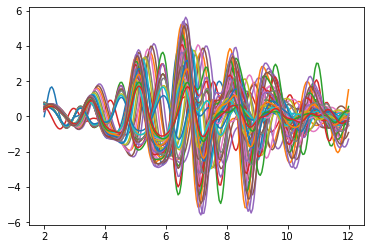

In [94]:
for i,boi in enumerate(special_bois):
    plt.plot(kspace, boi[0])

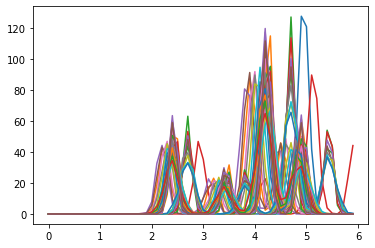

In [95]:
for i,boi in enumerate(special_bois):
    plt.plot(rmesh, boi[1])

In [116]:
# this function creates a random combination configurations and averages them
def combinator_s(num):
    num_special_bois = len(special_bois)
    # ran_i is the number of configurations to average
    ran_i = np.random.randint(1, 10, 1)
    # ran_bois is the indices of the configurations to average
    ran_bois = np.random.randint(0, num_special_bois, ran_i)
    # weights is the weights of the configurations to average
    weights = np.random.dirichlet(np.ones(ran_i),size=1)
    weights = weights[0]

    # exafs is at index 0 of special_bois
    exafs = [l[0] for l in special_bois[ran_bois]]
    exafs = np.array(exafs)
    # rdf_ni is at index 1 of special_bois
    rdf_ni = [l[1] for l in special_bois[ran_bois]]
    rdf_ni = np.array(rdf_ni)
    # exafs_weighted is the weighted average of the exafs
    exafs_weighted = np.average(exafs, axis=0, weights=weights)
    # rdf_ni_weighted is the weighted average of the rdf_ni
    rdf_ni_weighted = np.average(rdf_ni, axis=0, weights=weights)
    # return the exafs and rdf_ni. rdf_ni is sliced to only include the first peak
    return exafs_weighted, rdf_ni_weighted[15:55]

# generate examples
def generate_examples(num_examples):
    exafs_examples = []
    rdf_examples_ni = []
    for i in range(num_examples):
        # the argument of combinator_s has no meaning. fyi
        exafs_example, rdf_example_ni = combinator_s(3)
        exafs_examples.append(exafs_example)
        rdf_examples_ni.append(rdf_example_ni)
    exafs_examples = np.asarray(exafs_examples)
    rdf_examples_ni = np.asarray(rdf_examples_ni)

    return exafs_examples, rdf_examples_ni

# data generator for training NN. noise is added to the exafs
def data_generator(batch_size):
    while True:
        x_batch_0, y_batch = generate_examples(batch_size)
        x_batch = x_batch_0.reshape(x_batch_0.shape[0], x_batch_0.shape[1], 1)
        # noise level is random between 0 and 0.6
        n_level = np.random.uniform(low=0.0, high=0.6)
        noise = np.random.normal(loc=0, scale=n_level, size=x_batch.shape)
        yield x_batch+noise, y_batch

# The validation data is generated in the same way as the training data, but without noise
# train_test_split is used to split the data into training and validation data (i'm only using the validation data). There is no good reason to use this function, it was useful previously and stuck around to the final version.
exafs_examples = []
rdf_examples_ni = []
for i in range(200000):
    exafs_example, rdf_example_ni = combinator_s(100)
    exafs_examples.append(exafs_example)
    rdf_examples_ni.append(rdf_example_ni)
exafs_examples = np.asarray(exafs_examples)
rdf_examples_ni = np.asarray(rdf_examples_ni)

x_train_2, x_test, y_train_2, y_test = train_test_split(exafs_examples, rdf_examples_ni, test_size=0.33)

# reshape the data for the NN
x_test_rs = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

## Load validation data

In [98]:
# load the data
x_test_rs = pickle.load(open('.\\Data_Ni_Bulk\\NN\\Training_Data\\x_test_rs.pkl', 'rb'))
y_test = pickle.load(open('.\\Data_Ni_Bulk\\NN\\Training_Data\\y_test.pkl', 'rb'))

## Test Data: RMC-EXAFS

In [99]:
exafs_RMC = pickle.load(open(".\\Data_Ni_Bulk\\NN\Test_Data\\exafs_RMC.pkl", 'rb'))
rdf_RMC = pickle.load(open(".\\Data_Ni_Bulk\\NN\Test_Data\\rdf_RMC.pkl", 'rb'))

In [ ]:
# use the back fourier transform to filter the exafs (q-space)

In [100]:
mean_data=np.array([kspace,exafs_RMC]).T
kstep=0.05
nfft=2048
rmax_out=8
rstep = pi/(kstep*nfft)
irmax = int(min(nfft/2, 1.01 + rmax_out/rstep))
r= rstep * arange(irmax)
chi_data, window = xftf_prep(mean_data.transpose()[0], mean_data.transpose()[1], kmin=2, kmax=12, kweight=0, window='kaiser')
fftdata=xftf_fast(chi_data*window)
q_space = np.arange(2, 12, kstep)
rmc_chi_r= sqrt(fftdata.real**2 + fftdata.imag**2)[:irmax]
output = xftr(r=r[:irmax], chir=fftdata, rmin=1, rmax=6, with_phase=False, qmax_out=12, rw=0, window='kaiser', nfft=2048, kstep=0.05)
rmc_q = output["q"]
rmc_chi_q = output["chiq_re"]
rmc_chi_q_rs = intpol(np.array([rmc_q,rmc_chi_q]).T, kspace).reshape(1,201,1)

# NN Training

In [120]:
# Transformer

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

# Transformer parameters
d_model = 64
num_heads = 4
dff = 516
dropout_rate = 0.4

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

def transformer_encoder(d_model, num_heads, dff, rate=0.1):
    inputs = Input(shape=(None, d_model))
    attn_output, _ = MultiHeadSelfAttention(d_model, num_heads)(inputs, inputs, inputs, mask=None)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ffn_output = point_wise_feed_forward_network(d_model, dff)(out1)
    ffn_output = Dropout(rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return Model(inputs=inputs, outputs=out2)

# Define the input shape
input_shape = (201,1)
output_shape = (1, 40)

# Define the model architecture
inputs = Input(shape=input_shape)

# Dense layer to match the dimensions for the transformer
x = Dense(d_model)(inputs)

# Transformer encoder layer
x = transformer_encoder(d_model, num_heads, dff, dropout_rate)(x)

# GlobalAveragePooling1D will average the sequence dimension
x = tf.keras.layers.GlobalAveragePooling1D()(x)

# Output layer
outputs = Dense(output_shape[1])(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Print the model summary
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 201, 1)]          0         
                                                                 
 dense_16 (Dense)            (None, 201, 64)           128       
                                                                 
 model_4 (Functional)        (None, None, 64)          83524     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_23 (Dense)            (None, 40)                2600      
                                                                 
Total params: 86,252
Trainable params: 86,252
Non-trainable params: 0
_______________________________________________________

In [123]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path for the best weights
best_weights_path = ".\\Data_Ni_Bulk\\NN\\Training_Checkpoints\\best_weights.ckpt"

# Create a ModelCheckpoint callback to save the best weights
checkpoint_callback = ModelCheckpoint(filepath=best_weights_path,
                                      save_best_only=True,
                                      monitor='val_loss',
                                      mode='min',
                                      verbose=0)

if os.path.exists(best_weights_path):
    shutil.rmtree(best_weights_path)

# Assuming x_train, y_train, x_val, y_val are already defined
try:
    batch_size = 64
    steps_per_epoch = int(160000 / batch_size)  # or some other value that fits your dataset size

    #train_gen = data_generator(x_train, y_train, batch_size)

    model.fit(data_generator(batch_size), batch_size=batch_size, epochs=100, steps_per_epoch=steps_per_epoch, validation_data= (x_test_rs, y_test), callbacks=[checkpoint_callback])
except KeyboardInterrupt:
    print("\nInterrupted by user. Loading best weights and stopping training.")
    model.load_weights(best_weights_path)

Epoch 1/100


2497/2500 [============================>.] - ETA: 0s - loss: 99.2043

2500/2500 [==============================] - 37s 15ms/step - loss: 99.1738 - val_loss: 63.8968
Epoch 2/100
2500/2500 [==============================] - 34s 14ms/step - loss: 69.6778 - val_loss: 66.0328
Epoch 3/100
2498/2500 [============================>.] - ETA: 0s - loss: 66.8464

2500/2500 [==============================] - 36s 15ms/step - loss: 66.8384 - val_loss: 61.1141
Epoch 4/100
 648/2500 [======>.......................] - ETA: 22s - loss: 67.1279
Interrupted by user. Loading best weights and stopping training.


## Load model

In [131]:
model = keras.models.load_model(".\\Data_Ni_Bulk\\NN\\Model\\model")

# Predict on test data

1/1 [==============================] - 0s 145ms/step


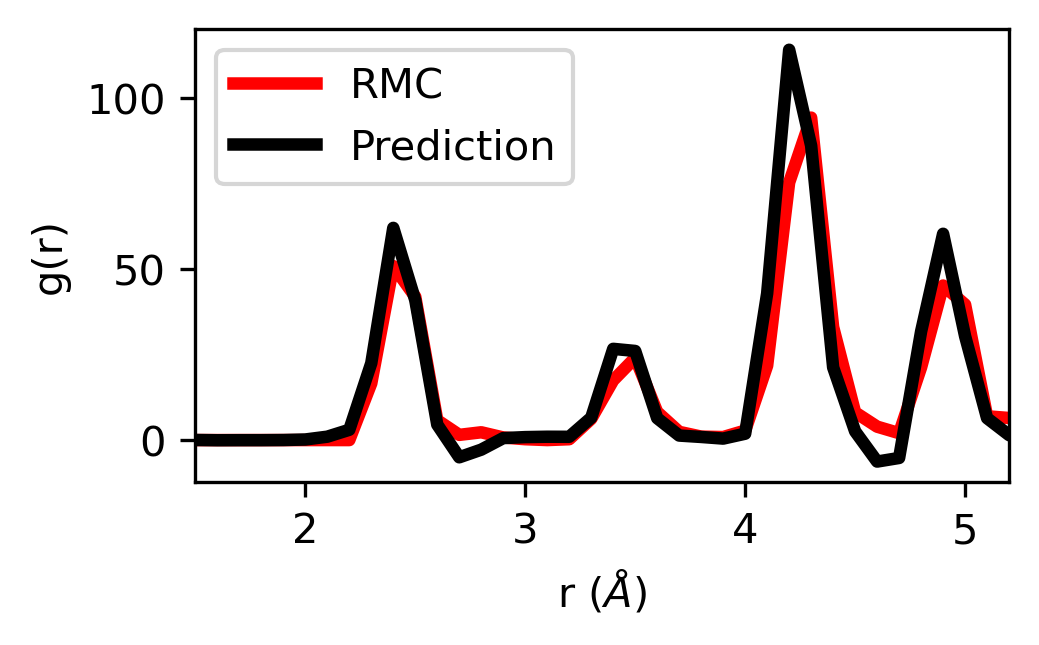

In [132]:
prediction = model.predict(rmc_chi_q_rs).reshape(-1,1)

fig, ax = plt.subplots(figsize=(3.5,2), dpi=300)

plt.plot(rmesh[15:55], rdf_RMC[15:55], color="red", linewidth=3, label="RMC")
plt.plot(rmesh[15:55], prediction.reshape(-1), color="black", linewidth=3, label="Prediction")
plt.xlim(1.5,5.2)
plt.xlabel("r ($\AA$)")
plt.ylabel("g(r)")
plt.legend()

## look at validation set predictions

In [125]:
all_predictions = model.predict(x_test_rs)

2063/2063 [==============================] - 9s 5ms/step


In [ ]:
# find the best 5 predictions and plot them
best_5 = np.argsort(np.mean(np.abs(all_predictions-y_test), axis=1))[:5]

for i in best_5:
    plt.plot(rmesh[15:55], all_predictions[i], color="black", linewidth=3, label="Prediction")
    plt.plot(rmesh[15:55], y_test[i], color="red", linewidth=3, label="RMC")
    plt.xlim(1.5,5.2)
    plt.xlabel("r ($\AA$)")
    plt.ylabel("g(r)")
    plt.legend()
    plt.show()

# find the worst 5 predictions and plot them
worst_5 = np.argsort(np.mean(np.abs(all_predictions-y_test), axis=1))[-5:]

for i in worst_5:
    plt.plot(rmesh[15:55], all_predictions[i], color="black", linewidth=3, label="Prediction")
    plt.plot(rmesh[15:55], y_test[i], color="red", linewidth=3, label="RMC")
    plt.xlim(1.5,5.2)
    plt.xlabel("r ($\AA$)")
    plt.ylabel("g(r)")
    plt.legend()
    plt.show()

# plot one in every 10 predictions from best agreement to worst agreement
for i in np.argsort(np.mean(np.abs(all_predictions-y_test), axis=1))[::10]:
    plt.plot(rmesh[15:55], all_predictions[i], color="black", linewidth=3, label="Prediction")
    plt.plot(rmesh[15:55], y_test[i], color="red", linewidth=3, label="RMC")
    plt.xlim(1.5,5.2)
    plt.xlabel("r ($\AA$)")
    plt.ylabel("g(r)")
    plt.legend()
    plt.show()




In [144]:
66000/13000

5.076923076923077

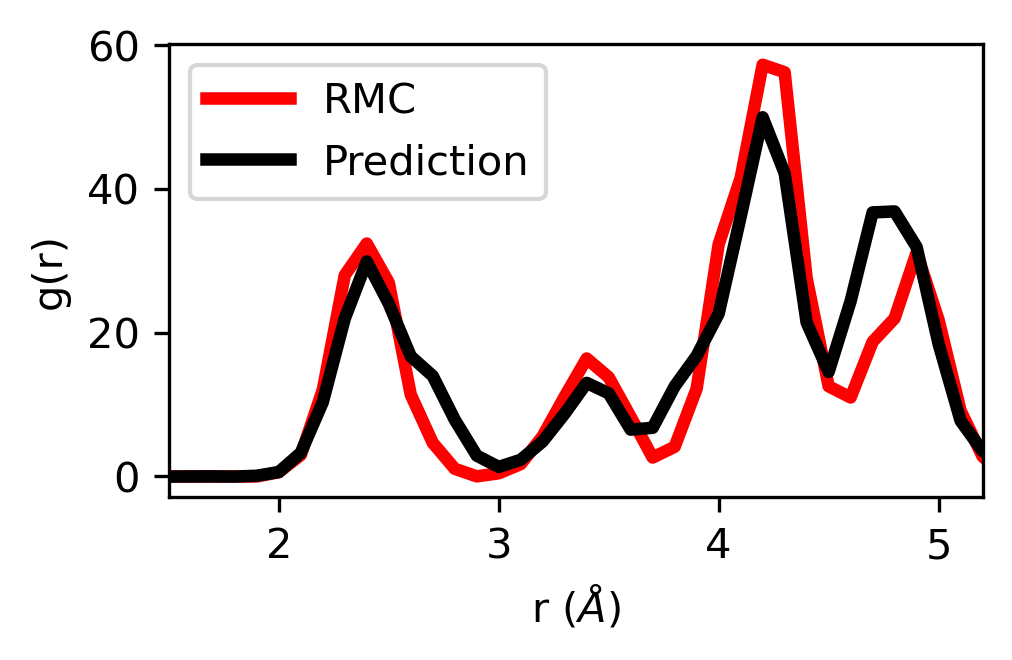

In [133]:
# e.g. index 200
fig, ax = plt.subplots(figsize=(3.5,2), dpi=300)

plt.plot(rmesh[15:55], y_test[200], color="red", linewidth=3, label="RMC")
plt.plot(rmesh[15:55], all_predictions[200].reshape(-1), color="black", linewidth=3, label="Prediction")
plt.xlim(1.5,5.2)
plt.xlabel("r ($\AA$)")
plt.ylabel("g(r)")
plt.legend()